In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import os
import pandas as pd
import sys
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import pickle

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
lineid = sys.argv[1]
# lineid = '45A_2'

## Read

In [5]:
df = pd.read_csv(f'../Final_DB/Lines/{lineid}/{lineid}.csv')
df.head()

,DAYOFSERVICE,STARTSTOP,LINEID,HOUR,ENDSTOP,JOURNEYTIME,PLANNED_JOURNEYTIME,STOP_TIME
0,2018-01-01,4533,45A_2,12,4844,58.0,59.0,0.0
1,2018-01-01,4844,45A_2,12,4177,197.0,218.0,13.0
2,2018-01-01,4177,45A_2,12,4178,48.0,41.0,22.0
3,2018-01-01,4178,45A_2,12,4142,69.0,83.0,0.0
4,2018-01-01,4142,45A_2,12,4143,75.0,62.0,23.0


In [6]:
df['DAYOFSERVICE'] = pd.to_datetime(df.DAYOFSERVICE)

df.dtypes

DAYOFSERVICE           datetime64[ns]
STARTSTOP                       int64
LINEID                         object
HOUR                            int64
ENDSTOP                         int64
JOURNEYTIME                   float64
PLANNED_JOURNEYTIME           float64
STOP_TIME                     float64
dtype: object

In [7]:
df['MONTH'] = df['DAYOFSERVICE'].dt.month_name()
df['DAY'] = df['DAYOFSERVICE'].dt.day_name()

In [8]:
df.drop(['DAYOFSERVICE'], axis = 1, inplace = True)

df.head()

,STARTSTOP,LINEID,HOUR,ENDSTOP,JOURNEYTIME,PLANNED_JOURNEYTIME,STOP_TIME,MONTH,DAY
0,4533,45A_2,12,4844,58.0,59.0,0.0,January,Monday
1,4844,45A_2,12,4177,197.0,218.0,13.0,January,Monday
2,4177,45A_2,12,4178,48.0,41.0,22.0,January,Monday
3,4178,45A_2,12,4142,69.0,83.0,0.0,January,Monday
4,4142,45A_2,12,4143,75.0,62.0,23.0,January,Monday


## remove outliers

In [9]:
start_end_pairs = df.groupby(['STARTSTOP', 'ENDSTOP']).size().reset_index().rename(columns = {0 : 'COUNT'})

In [10]:
start_end_pairs = start_end_pairs.sort_values(by=['COUNT'], ascending=False)

In [11]:
start_end_pairs.reset_index(inplace=True, drop=True)
start_end_pairs

,STARTSTOP,ENDSTOP,COUNT
0,3555,3556,7442
1,3556,3557,7442
2,3557,3560,7442
3,3560,7323,7442
4,3229,7472,7442
...,...,...,...
65,3548,3552,216
66,3545,3546,216
67,3546,3551,216
68,3547,3548,216


### ONROAD_TIME <= 0

In [12]:
df['ONROAD_TIME'] = df['JOURNEYTIME'] - df['STOP_TIME']

df.head()

,STARTSTOP,LINEID,HOUR,ENDSTOP,JOURNEYTIME,PLANNED_JOURNEYTIME,STOP_TIME,MONTH,DAY,ONROAD_TIME
0,4533,45A_2,12,4844,58.0,59.0,0.0,January,Monday,58.0
1,4844,45A_2,12,4177,197.0,218.0,13.0,January,Monday,184.0
2,4177,45A_2,12,4178,48.0,41.0,22.0,January,Monday,26.0
3,4178,45A_2,12,4142,69.0,83.0,0.0,January,Monday,69.0
4,4142,45A_2,12,4143,75.0,62.0,23.0,January,Monday,52.0


In [13]:
df[df['ONROAD_TIME'] <= 0]

,STARTSTOP,LINEID,HOUR,ENDSTOP,JOURNEYTIME,PLANNED_JOURNEYTIME,STOP_TIME,MONTH,DAY,ONROAD_TIME
235451,4151,45A_2,10,2997,55.0,36.0,55.0,May,Wednesday,0.0
256440,4151,45A_2,13,2997,254.0,44.0,254.0,June,Wednesday,0.0


In [14]:
df.drop(df[df['ONROAD_TIME'] <= 0].index, inplace = True)

df[df['ONROAD_TIME'] <= 0]

,STARTSTOP,LINEID,HOUR,ENDSTOP,JOURNEYTIME,PLANNED_JOURNEYTIME,STOP_TIME,MONTH,DAY,ONROAD_TIME


### outliers

In [15]:
for i in range(start_end_pairs.shape[0]):
    pair = str(start_end_pairs.loc[i, 'STARTSTOP']) + '_' + str(start_end_pairs.loc[i, 'ENDSTOP'])
    print(pair)
    
    data = df.loc[(df['STARTSTOP'] == start_end_pairs.loc[i, 'STARTSTOP']) & (df['ENDSTOP'] == start_end_pairs.loc[i, 'ENDSTOP'])]
   
    # clean the data
    outliers = data[(data['STOP_TIME'] > np.percentile(data['STOP_TIME'], 98)) | 
                    (data['STOP_TIME'] < np.percentile(data['STOP_TIME'], 1)) |
                    (data['ONROAD_TIME'] > np.percentile(data['ONROAD_TIME'], 98)) |
                    (data['ONROAD_TIME'] < np.percentile(data['ONROAD_TIME'], 1))]

    df.drop(outliers.index, inplace = True)

3555_3556
3556_3557
3557_3560
3560_7323
3229_7472
3225_3226
3226_3227
3227_3228
3228_3229
7323_3561
3554_3555
3553_3554
3240_3068
3561_3225
3068_3069
3069_3070
3070_4983
3140_3545
4206_3140
5090_4204
4204_4205
4203_5090
4205_4206
4202_4203
4201_4202
3552_3553
3239_3240
4416_4201
4154_4416
4153_4154
4150_4151
4151_2997
7472_3230
3238_3239
3230_3231
3045_4150
3237_3238
4169_4170
4170_4153
3236_3237
4156_4169
3231_3246
3246_3247
3247_7056
4143_4144
3248_3343
7056_3248
3343_3236
2997_4156
4142_4143
4149_3045
4178_4142
4533_4844
4177_4178
4844_4177
3545_3552
4144_5088
5088_5089
4176_4149
5089_4176
4148_4149
4144_4145
4145_4146
4304_4148
4146_4304
3548_3552
3545_3546
3546_3551
3547_3548
3551_3547


## Rush Hour

In [16]:
df['HOUR_BIN'] = pd.cut(x = df['HOUR'], bins = [0, 8, 20, 23], labels = [0, 1, 2])
df['RUSH_HOUR'] = 0

In [17]:
df.loc[df['HOUR_BIN'] == 1, 'RUSH_HOUR'] = 1

In [18]:
df.drop(['HOUR_BIN'], axis = 1, inplace = True)

df.head()

,STARTSTOP,LINEID,HOUR,ENDSTOP,JOURNEYTIME,PLANNED_JOURNEYTIME,STOP_TIME,MONTH,DAY,ONROAD_TIME,RUSH_HOUR
0,4533,45A_2,12,4844,58.0,59.0,0.0,January,Monday,58.0,1
1,4844,45A_2,12,4177,197.0,218.0,13.0,January,Monday,184.0,1
2,4177,45A_2,12,4178,48.0,41.0,22.0,January,Monday,26.0,1
3,4178,45A_2,12,4142,69.0,83.0,0.0,January,Monday,69.0,1
4,4142,45A_2,12,4143,75.0,62.0,23.0,January,Monday,52.0,1


## Weekday

In [19]:
df['WEEKDAY'] = 0

In [20]:
df.loc[((df['DAY'] == 'Saturday') | (df['DAY'] == 'Sunday')), 'WEEKDAY'] = 1

df.head()

,STARTSTOP,LINEID,HOUR,ENDSTOP,JOURNEYTIME,PLANNED_JOURNEYTIME,STOP_TIME,MONTH,DAY,ONROAD_TIME,RUSH_HOUR,WEEKDAY
0,4533,45A_2,12,4844,58.0,59.0,0.0,January,Monday,58.0,1,0
1,4844,45A_2,12,4177,197.0,218.0,13.0,January,Monday,184.0,1,0
2,4177,45A_2,12,4178,48.0,41.0,22.0,January,Monday,26.0,1,0
3,4178,45A_2,12,4142,69.0,83.0,0.0,January,Monday,69.0,1,0
4,4142,45A_2,12,4143,75.0,62.0,23.0,January,Monday,52.0,1,0


### outliers

In [32]:
for i in range(start_end_pairs.shape[0]):
    pair = str(start_end_pairs.loc[i, 'STARTSTOP']) + '_' + str(start_end_pairs.loc[i, 'ENDSTOP'])
    print(pair)
    
    data = df.loc[(df['STARTSTOP'] == start_end_pairs.loc[i, 'STARTSTOP']) & (df['ENDSTOP'] == start_end_pairs.loc[i, 'ENDSTOP'])]
    
    # remove outliers
    if (data['RUSH_HOUR'].nunique() == 2):
        outliers = data[(data.loc[data['RUSH_HOUR'] != 1, 'ONROAD_TIME'] > np.percentile(data.loc[data['RUSH_HOUR'] == 1, 'ONROAD_TIME'], 99)) | 
                        (data.loc[data['RUSH_HOUR'] != 1, 'STOP_TIME'] >  np.percentile(data.loc[data['RUSH_HOUR'] == 1, 'STOP_TIME'], 99)) | 
                        (data.loc[data['RUSH_HOUR'] == 1, 'ONROAD_TIME'] < np.percentile(data.loc[data['RUSH_HOUR'] != 1, 'ONROAD_TIME'], 1)) | 
                        (data.loc[data['RUSH_HOUR'] == 1, 'STOP_TIME'] <  np.percentile(data.loc[data['RUSH_HOUR'] != 1, 'STOP_TIME'], 1))]
    
        df.drop(outliers.index, inplace = True)

3555_3556
3556_3557
3557_3560
3560_7323
3229_7472
3225_3226
3226_3227
3227_3228
3228_3229
7323_3561
3554_3555
3553_3554
3240_3068
3561_3225
3068_3069
3069_3070
3070_4983
3140_3545
4206_3140
5090_4204
4204_4205
4203_5090
4205_4206
4202_4203
4201_4202
3552_3553
3239_3240
4416_4201
4154_4416
4153_4154
4150_4151
4151_2997
7472_3230
3238_3239
3230_3231
3045_4150
3237_3238
4169_4170
4170_4153
3236_3237
4156_4169
3231_3246
3246_3247
3247_7056
4143_4144
3248_3343
7056_3248
3343_3236
2997_4156
4142_4143
4149_3045
4178_4142
4533_4844
4177_4178
4844_4177
3545_3552
4144_5088
5088_5089
4176_4149
5089_4176
4148_4149
4144_4145
4145_4146
4304_4148
4146_4304
3548_3552
3545_3546
3546_3551
3547_3548
3551_3547


In [35]:
for i in range(start_end_pairs.shape[0]):
    pair = str(start_end_pairs.loc[i, 'STARTSTOP']) + '_' + str(start_end_pairs.loc[i, 'ENDSTOP'])
    print(pair)
    
    data = df.loc[(df['STARTSTOP'] == start_end_pairs.loc[i, 'STARTSTOP']) & (df['ENDSTOP'] == start_end_pairs.loc[i, 'ENDSTOP'])]
    
    if (data['WEEKDAY'].nunique() == 2):
    # remove outliers
        outliers = data[(data.loc[data['WEEKDAY'] != 1, 'ONROAD_TIME'] > np.percentile(data.loc[data['WEEKDAY'] == 1, 'ONROAD_TIME'], 99)) | 
                        (data.loc[data['WEEKDAY'] != 1, 'STOP_TIME'] >  np.percentile(data.loc[data['WEEKDAY'] == 1, 'STOP_TIME'], 99)) | 
                        (data.loc[data['WEEKDAY'] == 1, 'ONROAD_TIME'] < np.percentile(data.loc[data['WEEKDAY'] != 1, 'ONROAD_TIME'], 1)) | 
                        (data.loc[data['WEEKDAY'] == 1, 'STOP_TIME'] <  np.percentile(data.loc[data['WEEKDAY'] != 1, 'STOP_TIME'], 1))]
    
        df.drop(outliers.index, inplace = True)

3555_3556
3556_3557
3557_3560
3560_7323
3229_7472
3225_3226
3226_3227
3227_3228
3228_3229
7323_3561
3554_3555
3553_3554
3240_3068
3561_3225
3068_3069
3069_3070
3070_4983
3140_3545
4206_3140
5090_4204
4204_4205
4203_5090
4205_4206
4202_4203
4201_4202
3552_3553
3239_3240
4416_4201
4154_4416
4153_4154
4150_4151
4151_2997
7472_3230
3238_3239
3230_3231
3045_4150
3237_3238
4169_4170
4170_4153
3236_3237
4156_4169
3231_3246
3246_3247
3247_7056
4143_4144
3248_3343
7056_3248
3343_3236
2997_4156
4142_4143
4149_3045
4178_4142
4533_4844
4177_4178
4844_4177
3545_3552
4144_5088
5088_5089
4176_4149
5089_4176
4148_4149
4144_4145
4145_4146
4304_4148
4146_4304
3548_3552
3545_3546
3546_3551
3547_3548
3551_3547


### ONROAD_TIME + STOP_TIME, PLANNED_JOURNEYTIME 

In [36]:
for i in range(start_end_pairs.shape[0]):
    pair = str(start_end_pairs.loc[i, 'STARTSTOP']) + '_' + str(start_end_pairs.loc[i, 'ENDSTOP'])
    print(pair)
    
    data = df.loc[(df['STARTSTOP'] == start_end_pairs.loc[i, 'STARTSTOP']) & (df['ENDSTOP'] == start_end_pairs.loc[i, 'ENDSTOP'])]
    
    # onroad_time is supposed to be very close to planned_journeytime
    outliers = data[((data['ONROAD_TIME'] + data['STOP_TIME'].max()) < data['PLANNED_JOURNEYTIME']) | 
                    ((data['ONROAD_TIME'].max() + data['STOP_TIME']) < data['PLANNED_JOURNEYTIME']) |
                    ((data['ONROAD_TIME'].min() + data['STOP_TIME']) > data['PLANNED_JOURNEYTIME'])]
    
    df.drop(outliers.index, inplace = True)

3555_3556
3556_3557
3557_3560
3560_7323
3229_7472
3225_3226
3226_3227
3227_3228
3228_3229
7323_3561
3554_3555
3553_3554
3240_3068
3561_3225
3068_3069
3069_3070
3070_4983
3140_3545
4206_3140
5090_4204
4204_4205
4203_5090
4205_4206
4202_4203
4201_4202
3552_3553
3239_3240
4416_4201
4154_4416
4153_4154
4150_4151
4151_2997
7472_3230
3238_3239
3230_3231
3045_4150
3237_3238
4169_4170
4170_4153
3236_3237
4156_4169
3231_3246
3246_3247
3247_7056
4143_4144
3248_3343
7056_3248
3343_3236
2997_4156
4142_4143
4149_3045
4178_4142
4533_4844
4177_4178
4844_4177
3545_3552
4144_5088
5088_5089
4176_4149
5089_4176
4148_4149
4144_4145
4145_4146
4304_4148
4146_4304
3548_3552
3545_3546
3546_3551
3547_3548
3551_3547


### zscore < 3

3555_3556


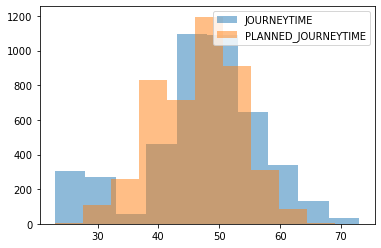

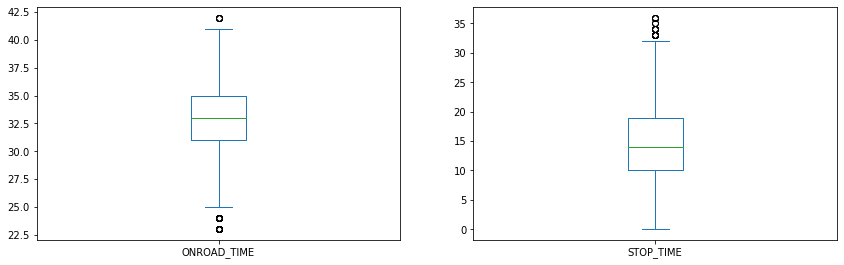

3556_3557


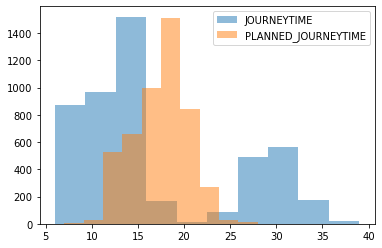

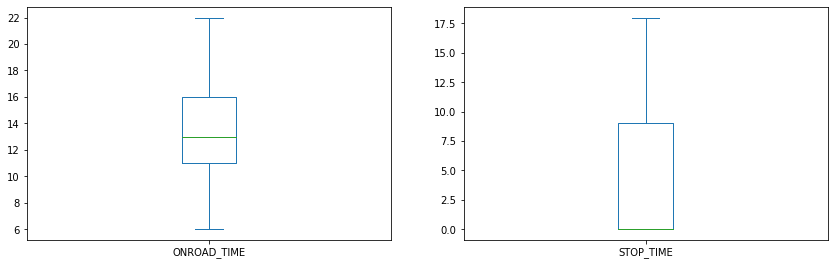

3557_3560


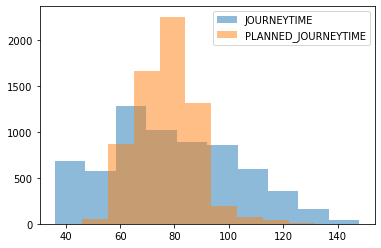

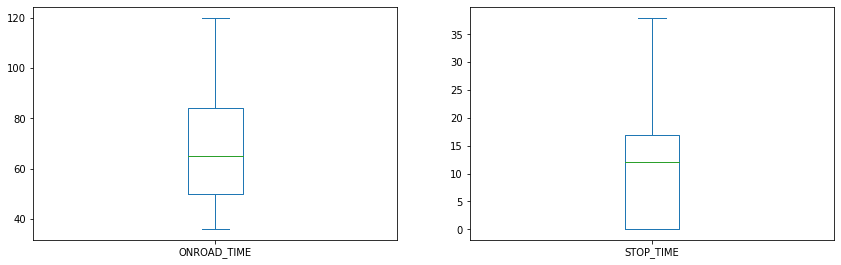

3560_7323


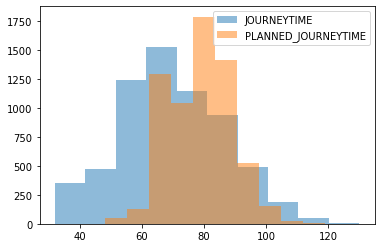

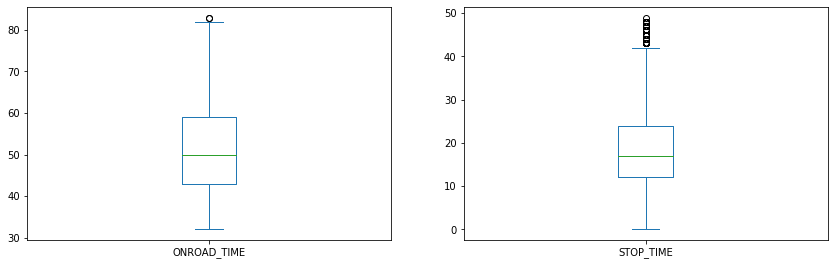

3229_7472


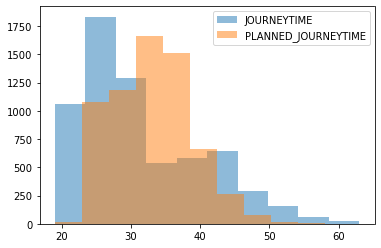

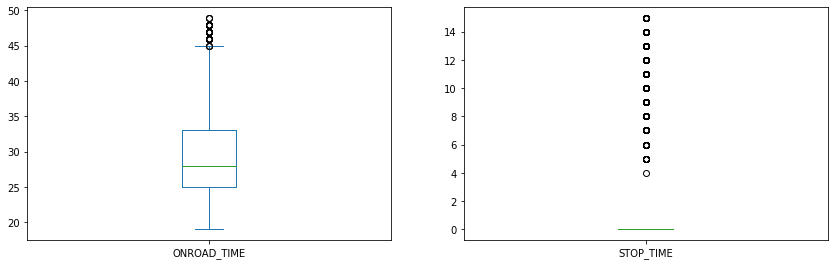

3225_3226


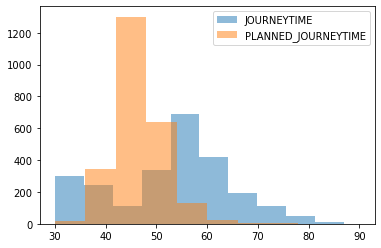

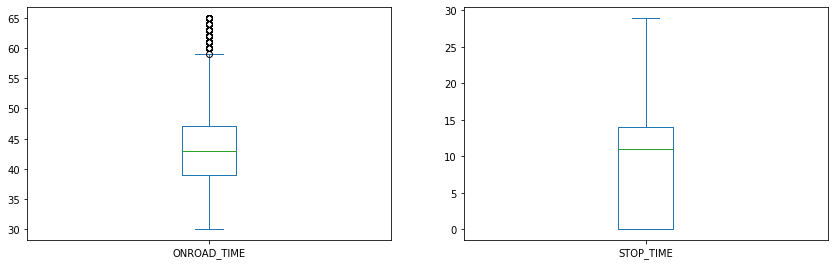

3226_3227


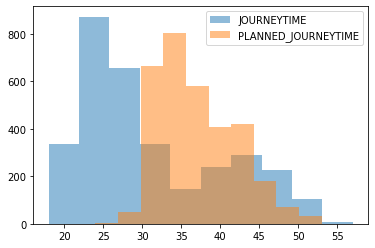

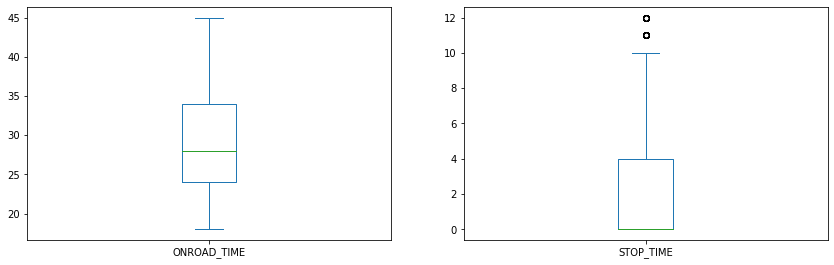

3227_3228


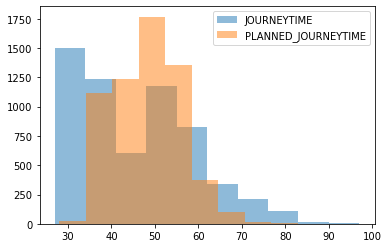

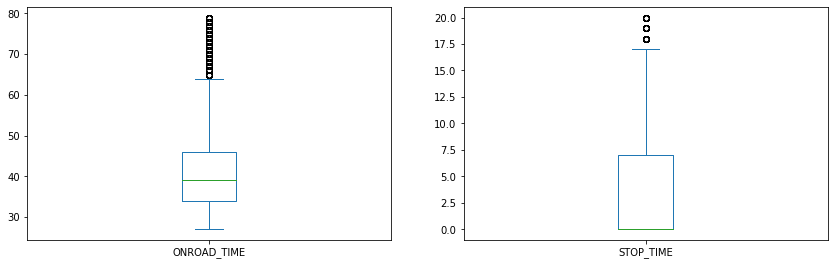

3228_3229


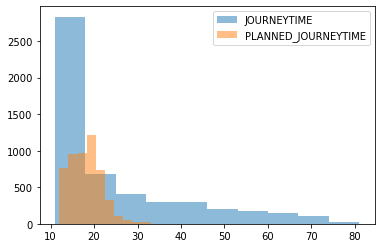

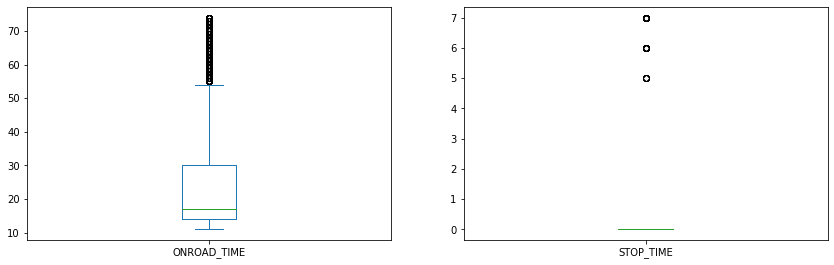

7323_3561


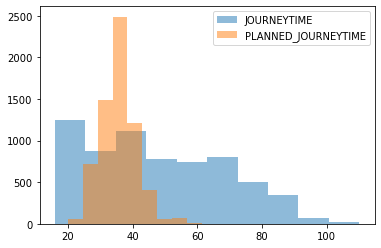

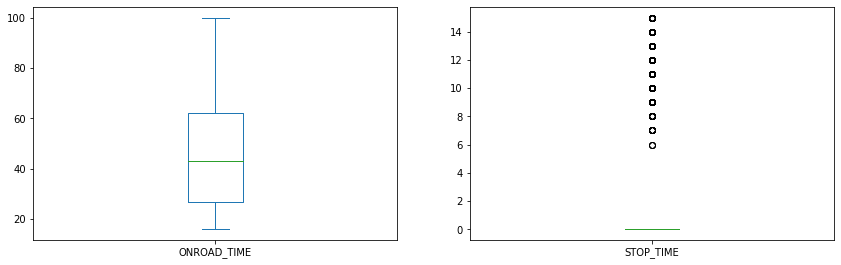

3554_3555


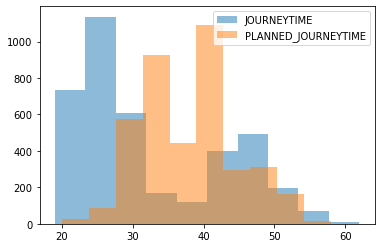

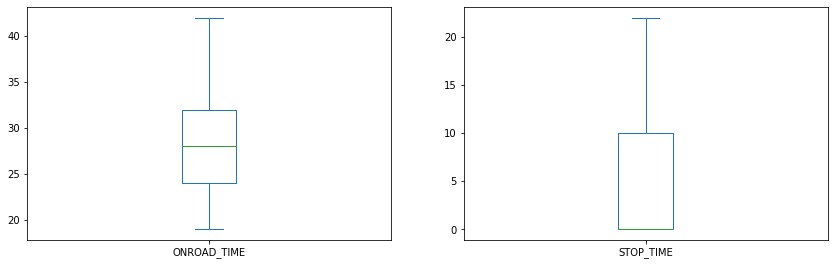

3553_3554


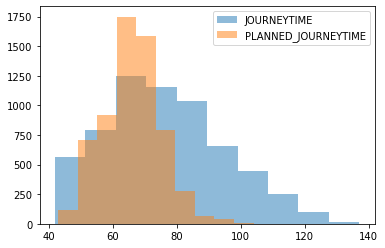

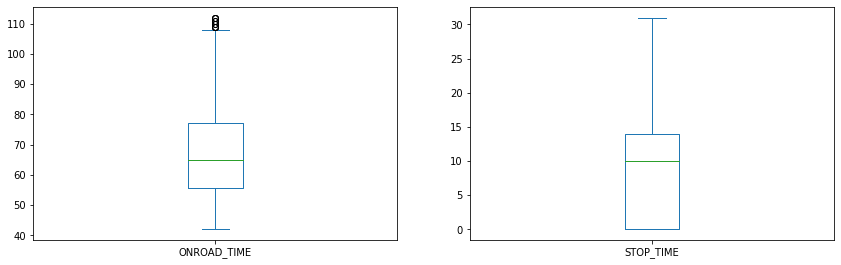

3240_3068


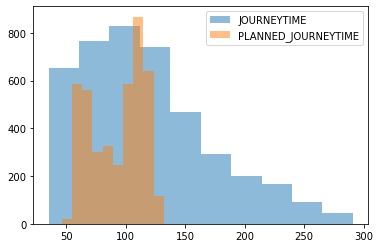

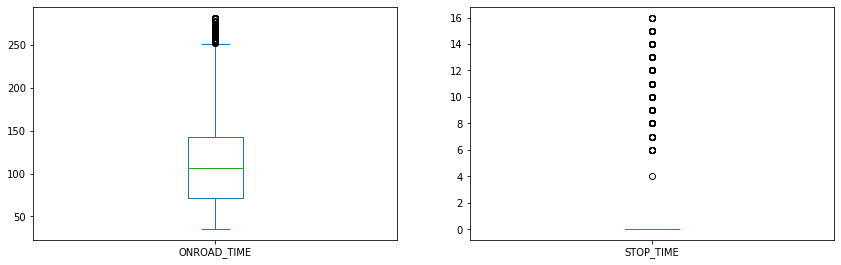

3561_3225


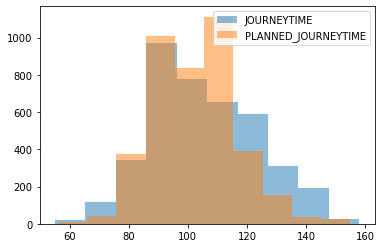

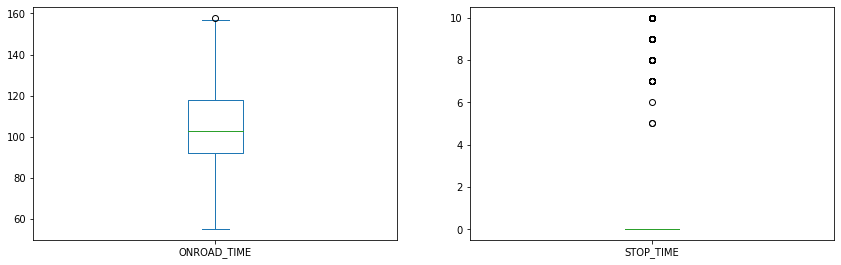

3068_3069


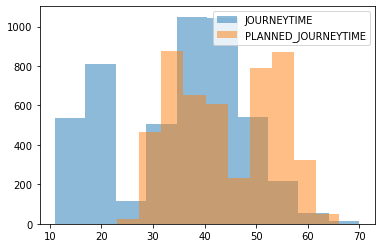

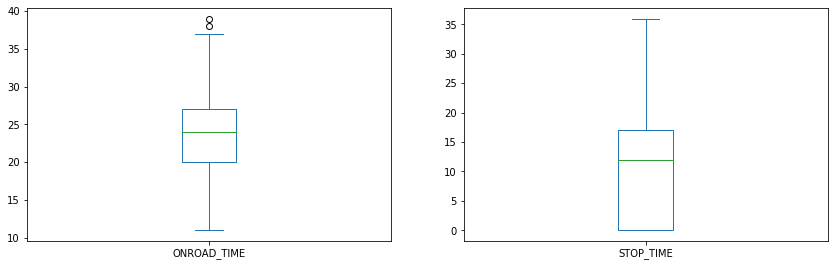

3069_3070


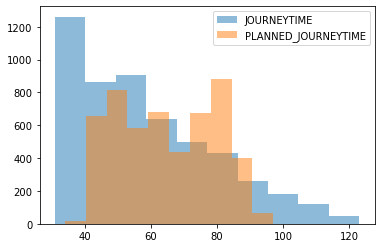

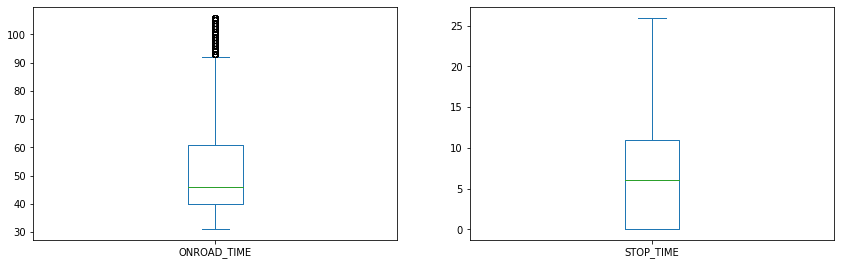

3070_4983


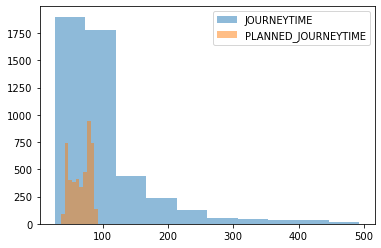

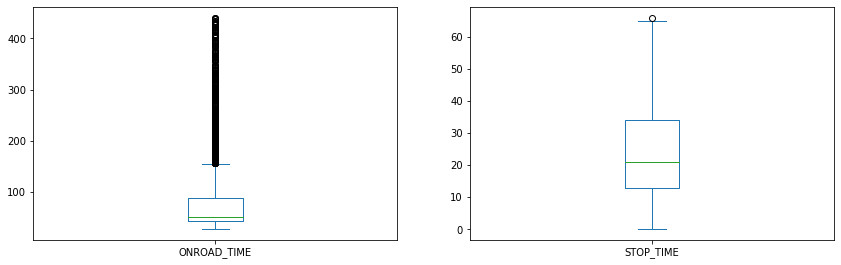

3140_3545


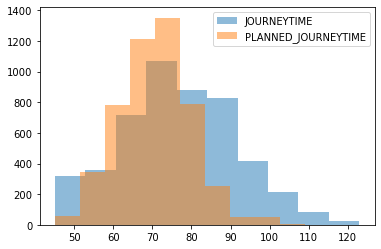

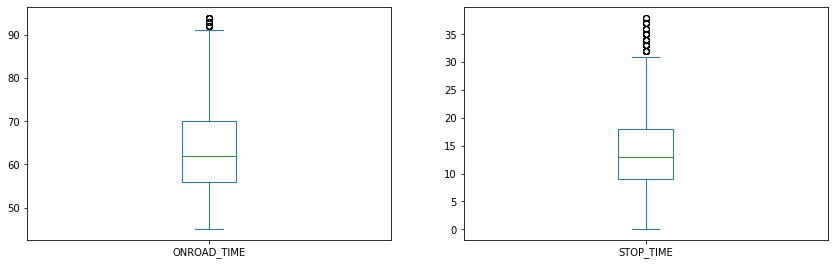

4206_3140


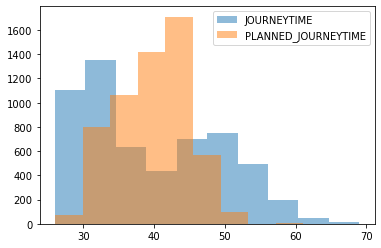

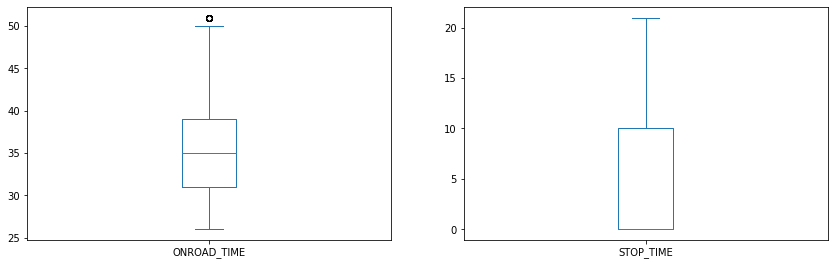

5090_4204


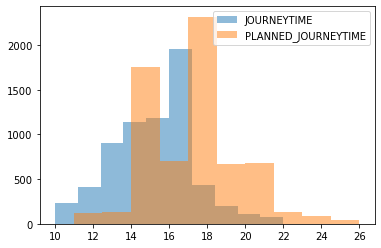

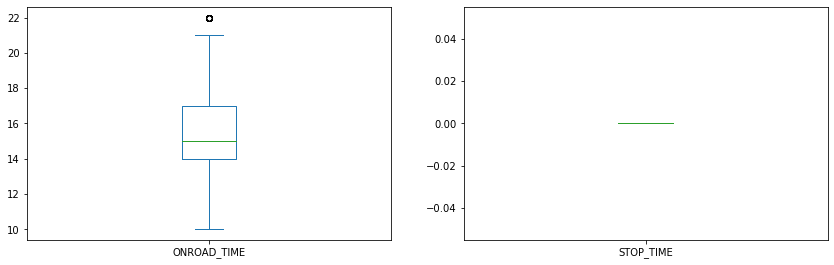

4204_4205


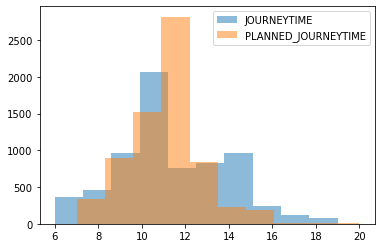

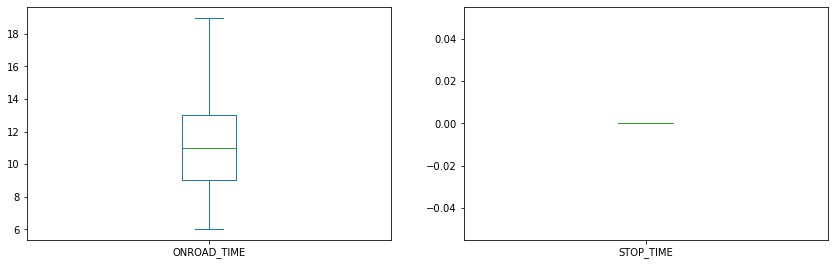

4203_5090


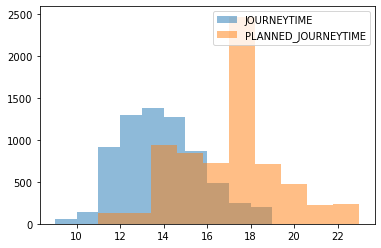

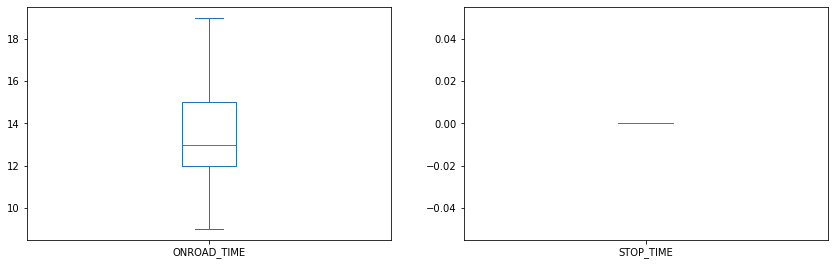

4205_4206


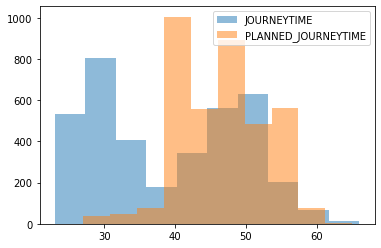

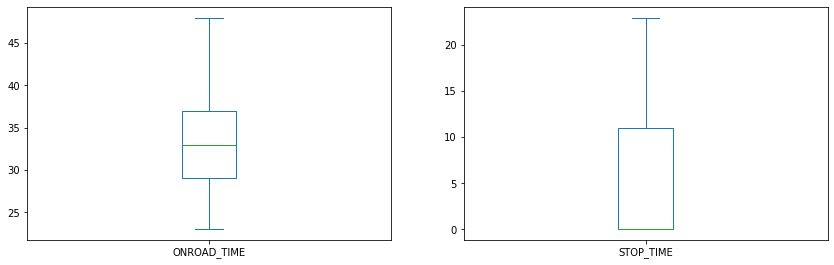

4202_4203


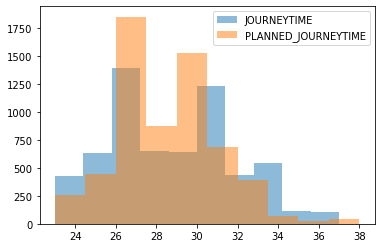

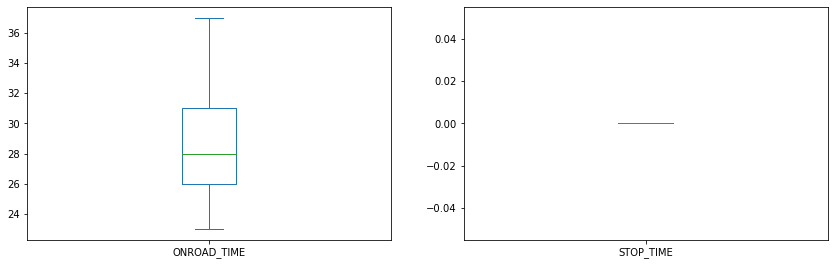

4201_4202


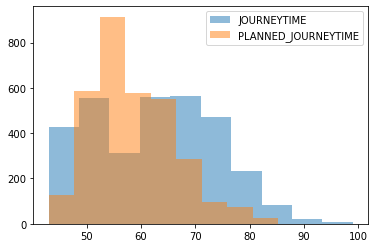

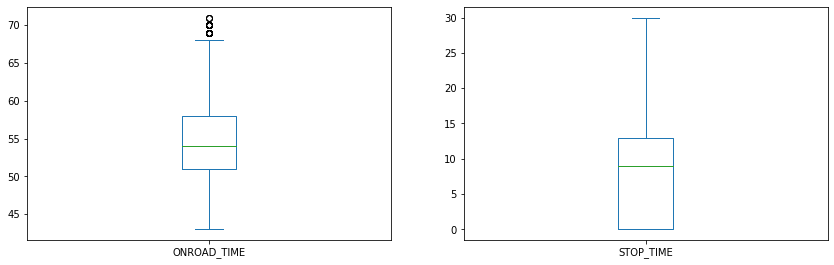

3552_3553


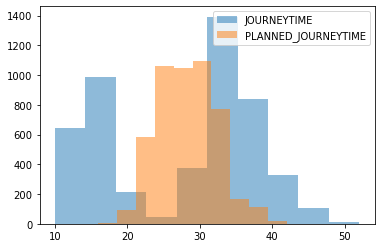

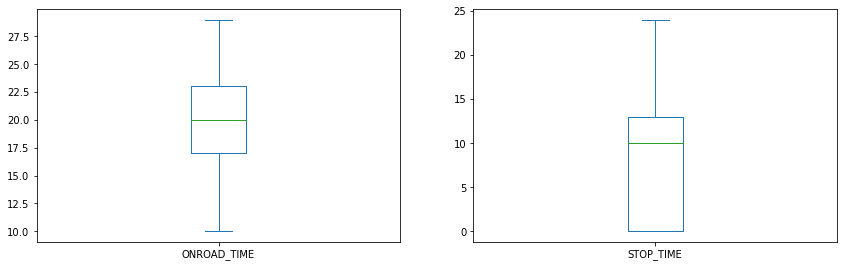

3239_3240


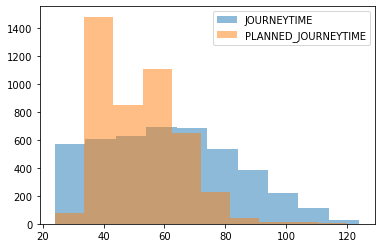

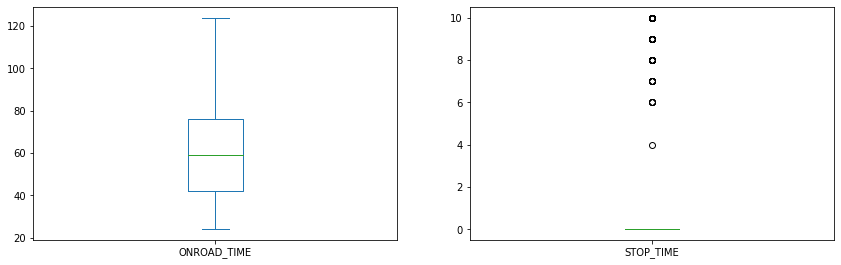

4416_4201


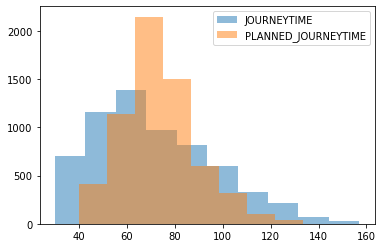

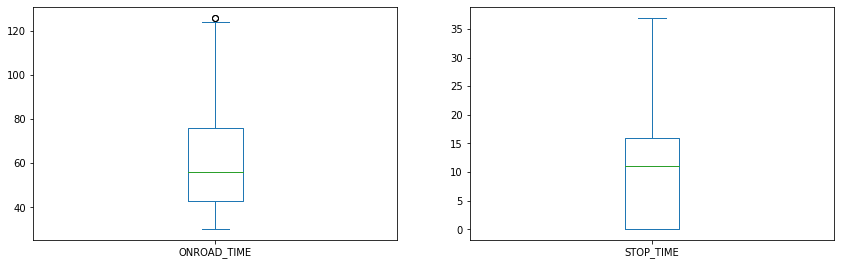

4154_4416


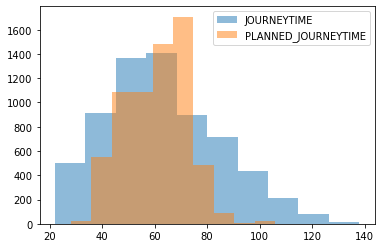

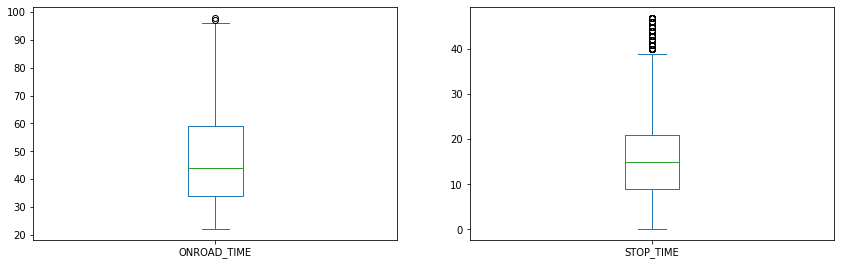

4153_4154


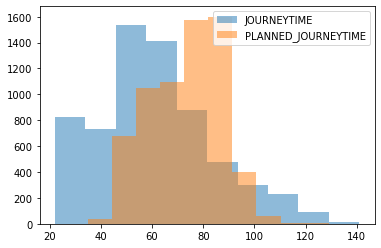

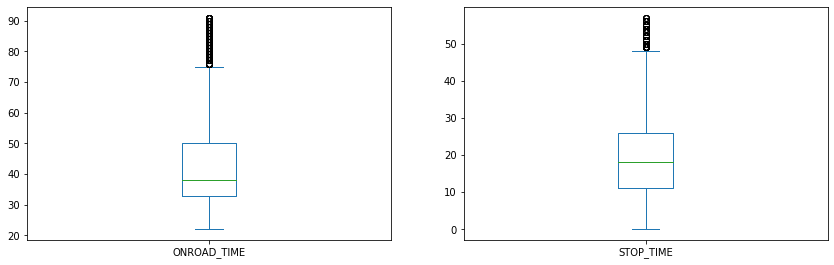

4150_4151


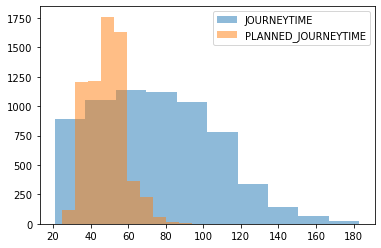

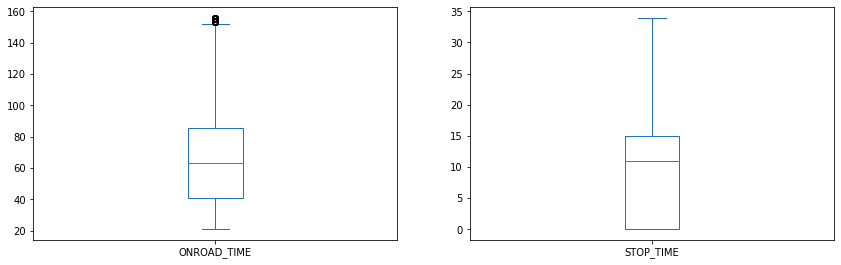

4151_2997


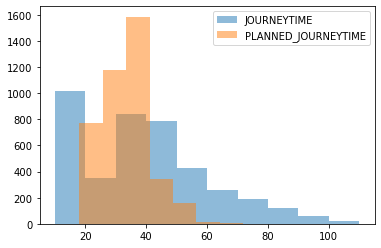

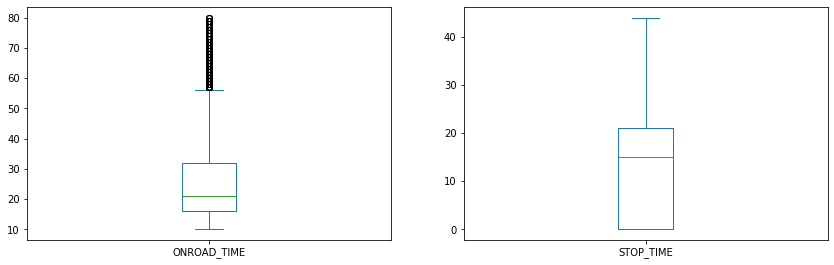

7472_3230


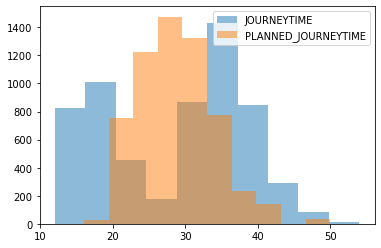

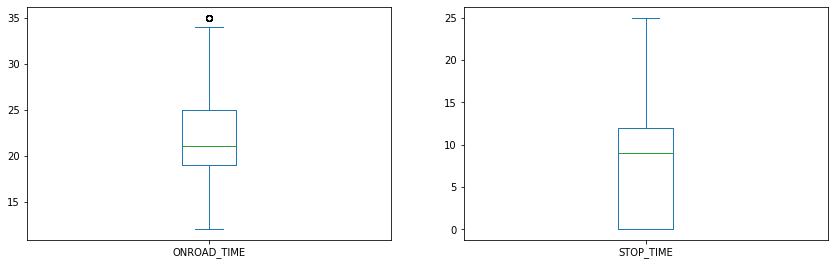

3238_3239


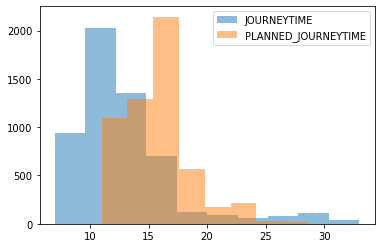

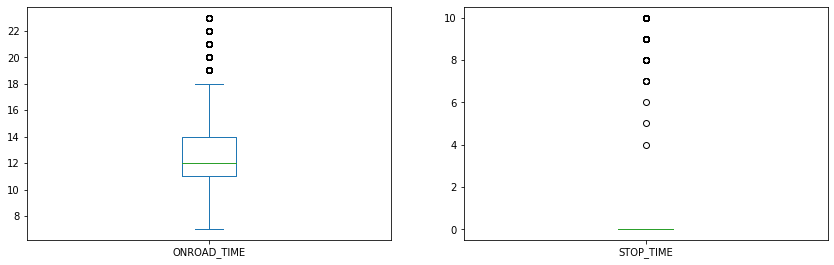

3230_3231


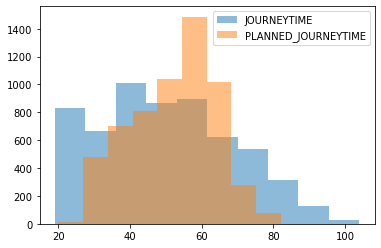

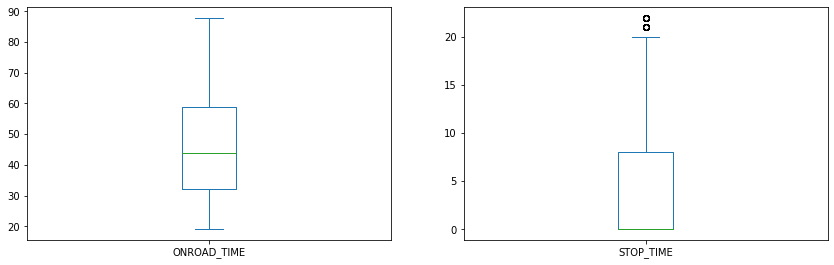

3045_4150


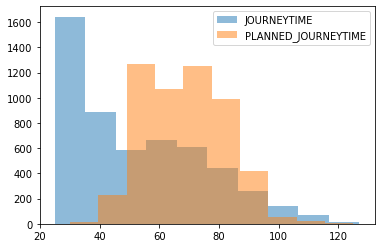

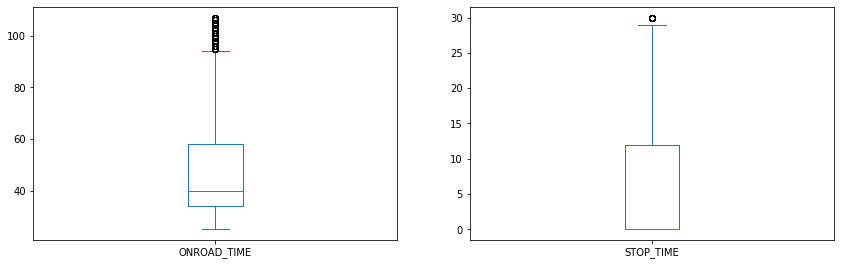

3237_3238


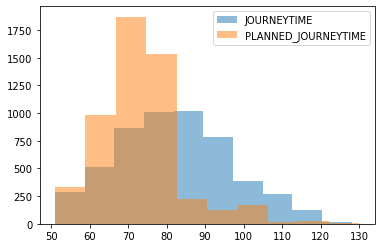

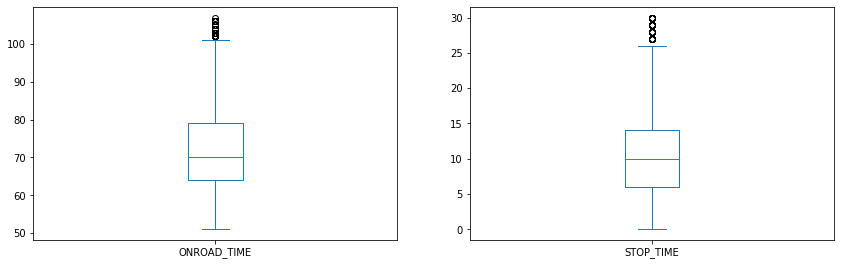

4169_4170


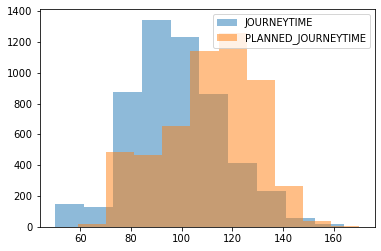

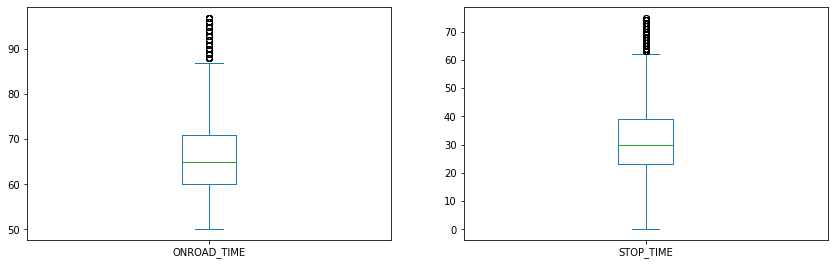

4170_4153


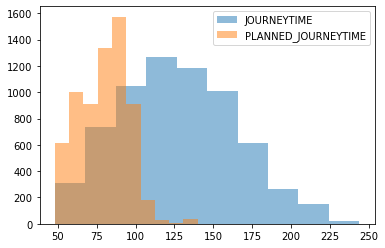

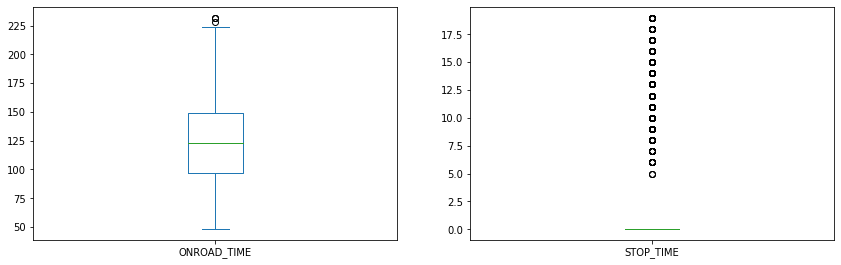

3236_3237


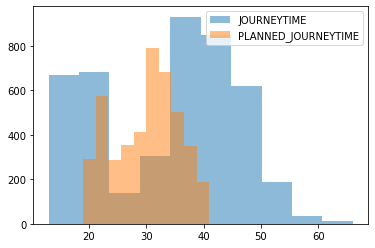

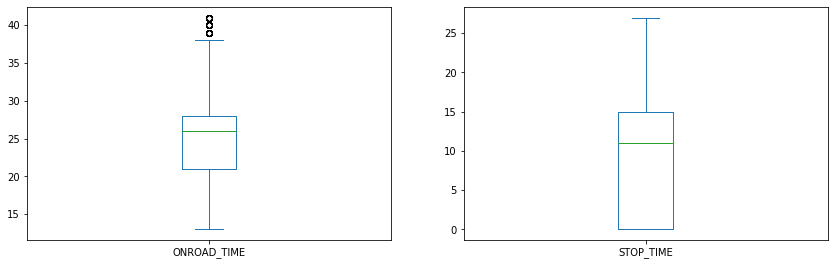

4156_4169


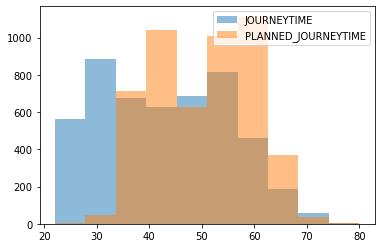

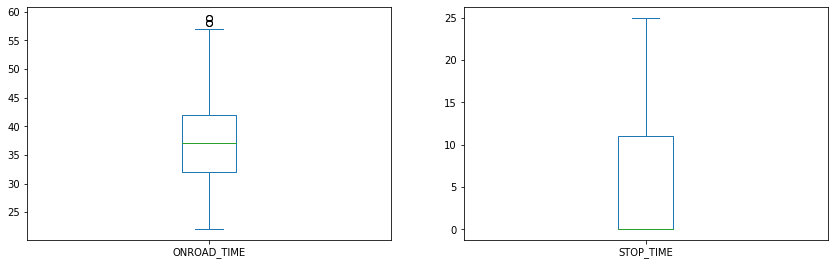

3231_3246


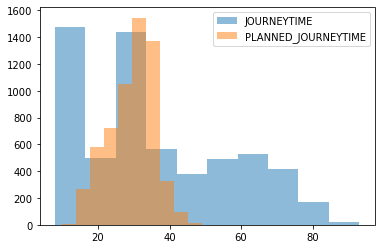

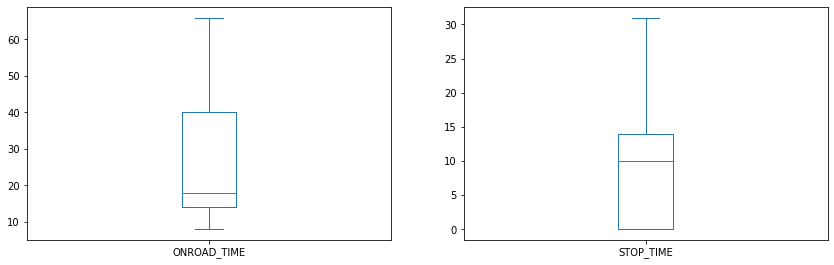

3246_3247


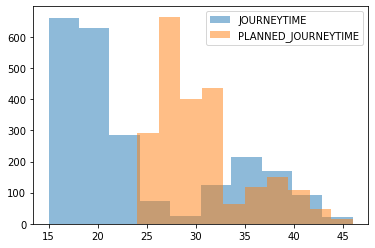

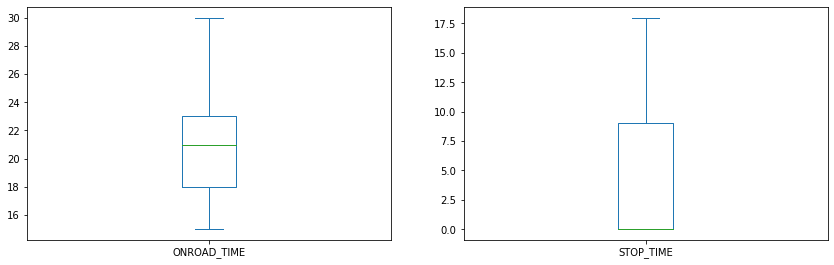

3247_7056


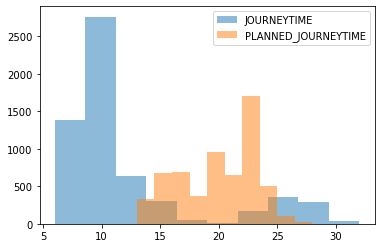

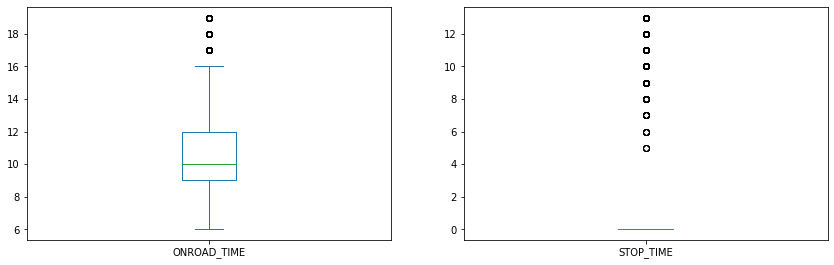

4143_4144


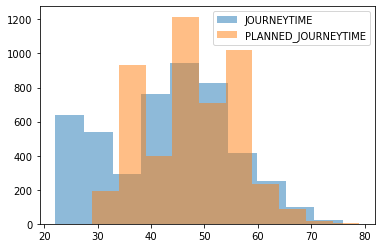

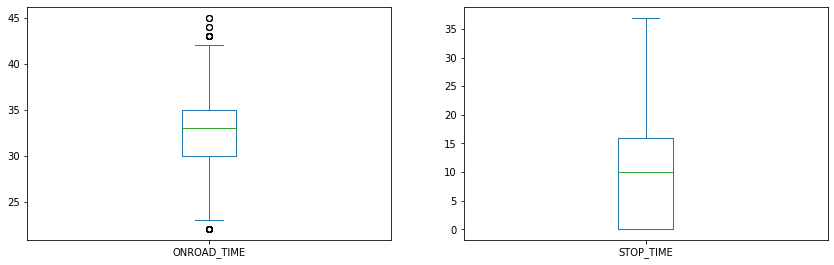

3248_3343


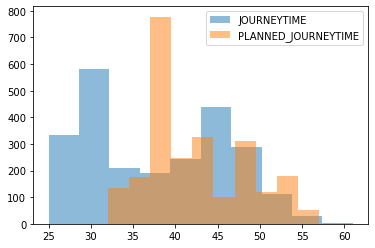

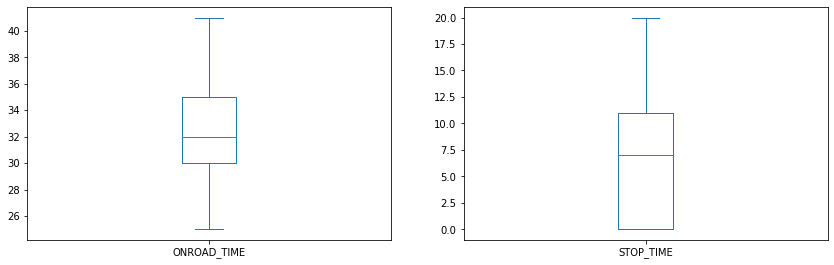

7056_3248


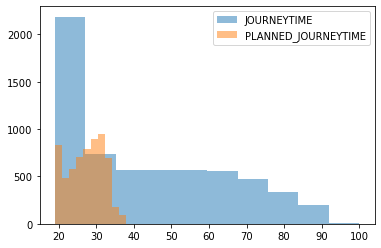

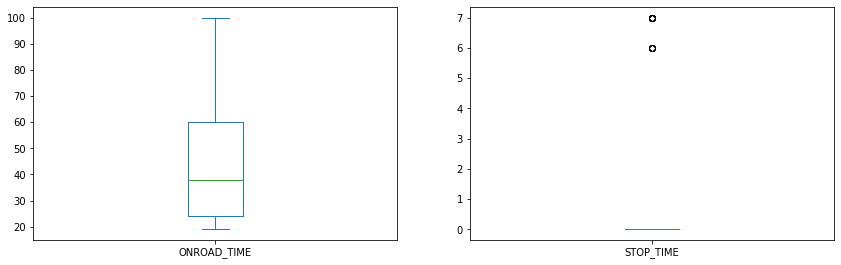

3343_3236


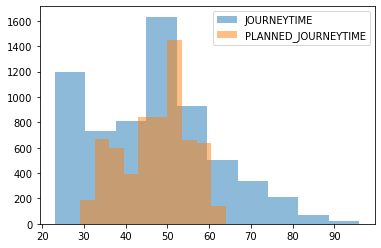

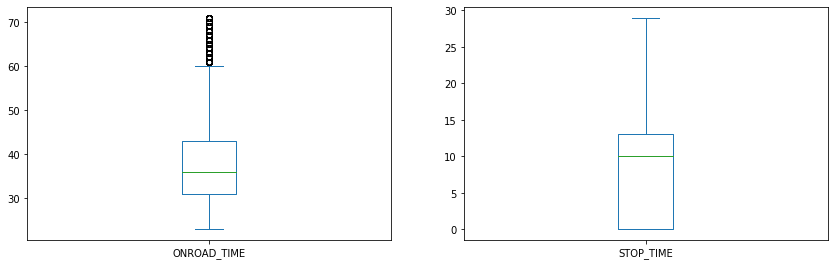

2997_4156


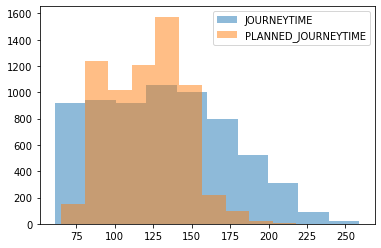

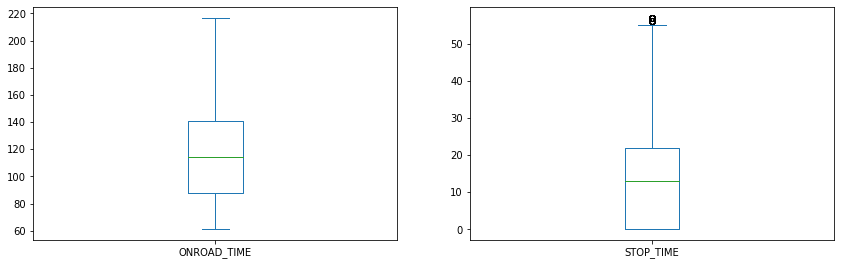

4142_4143


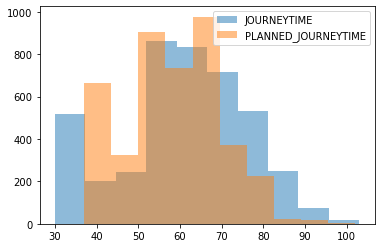

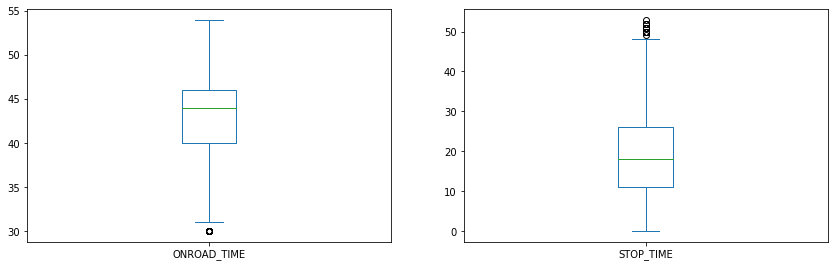

4149_3045


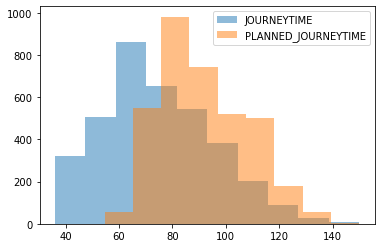

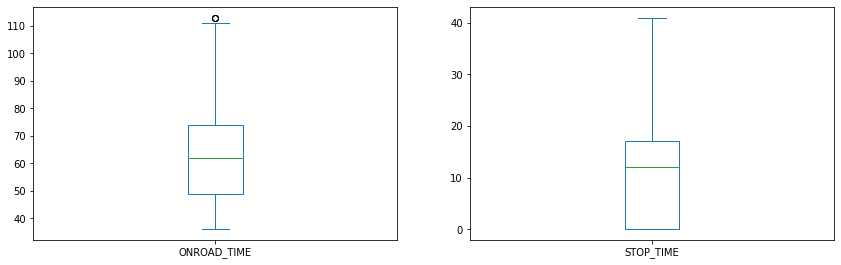

4178_4142


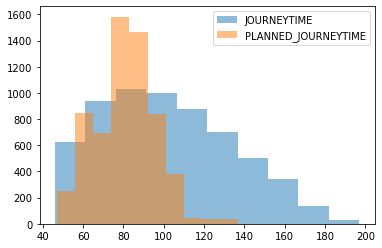

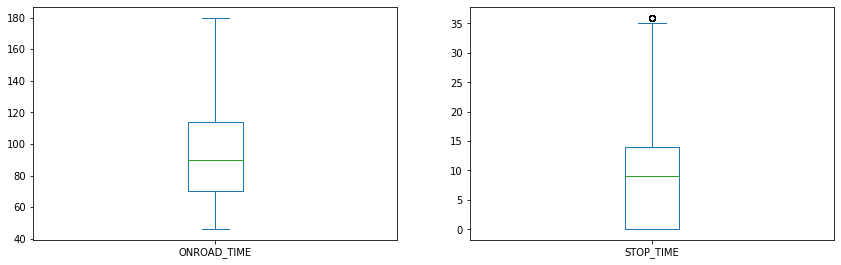

4533_4844


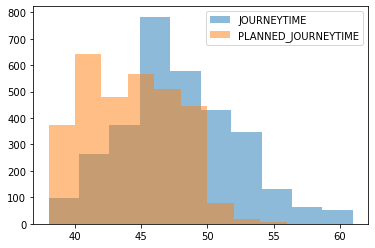

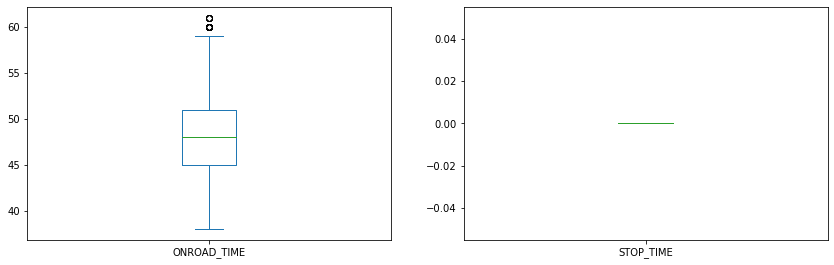

4177_4178


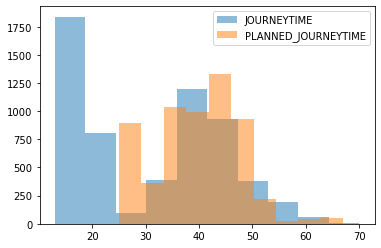

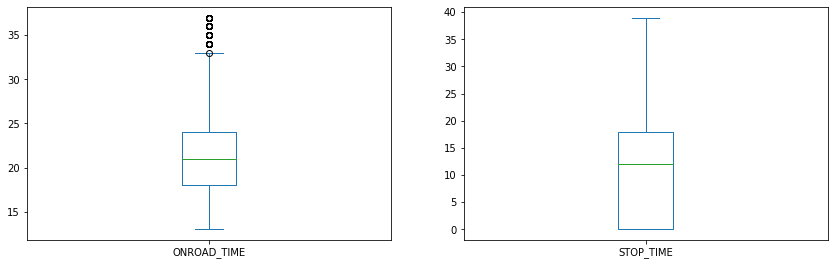

4844_4177


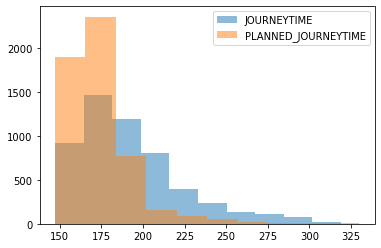

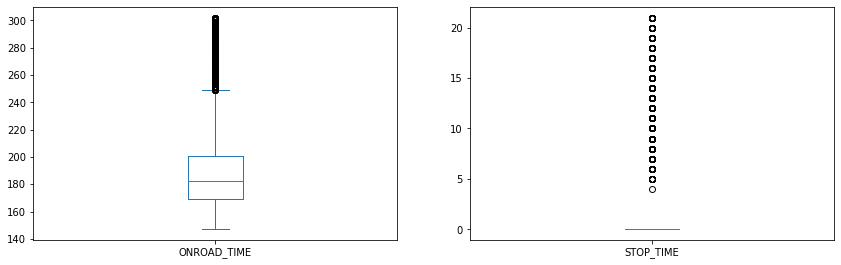

3545_3552


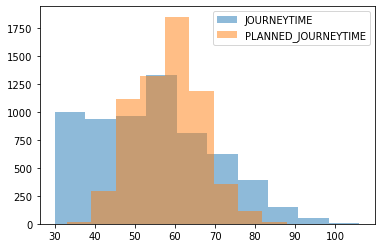

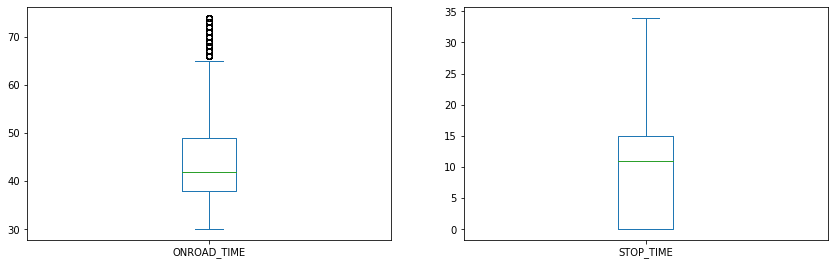

4144_5088


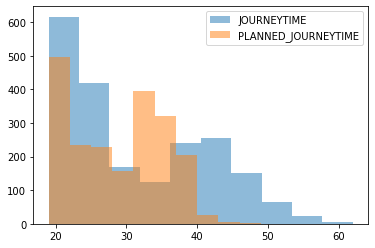

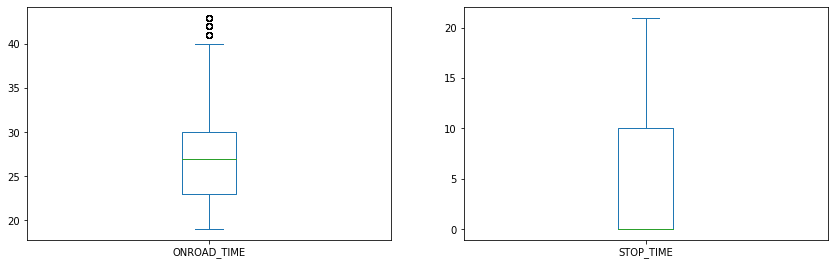

5088_5089


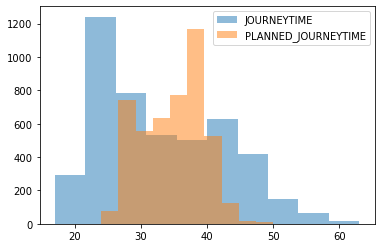

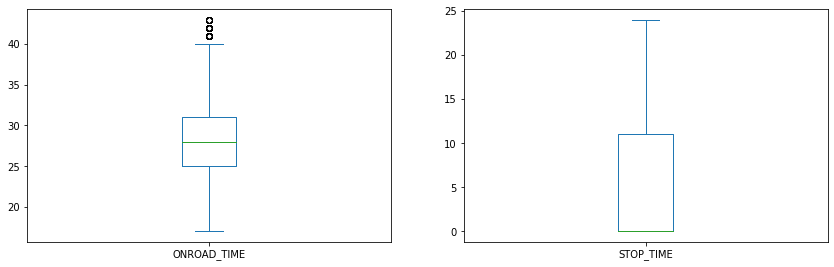

4176_4149


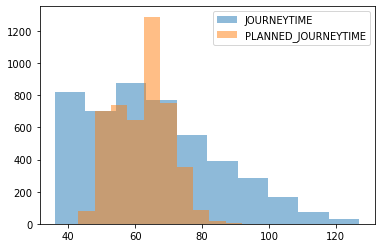

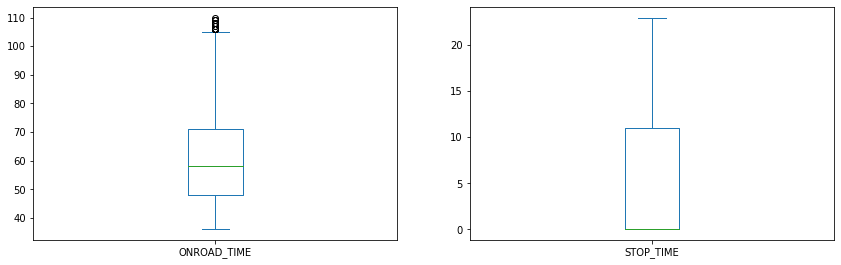

5089_4176


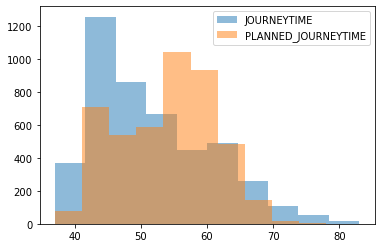

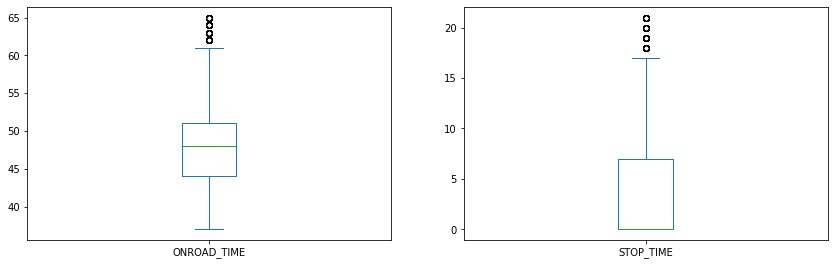

4148_4149


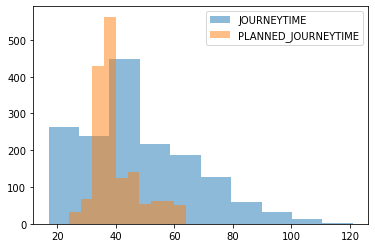

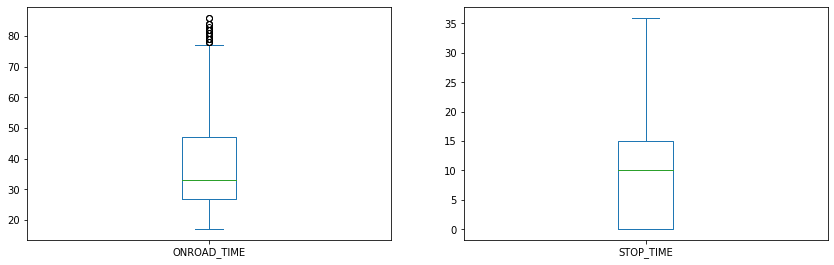

4144_4145


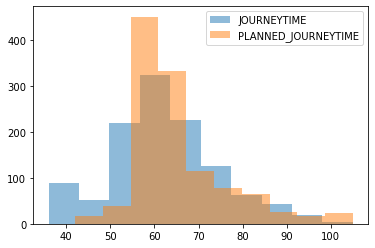

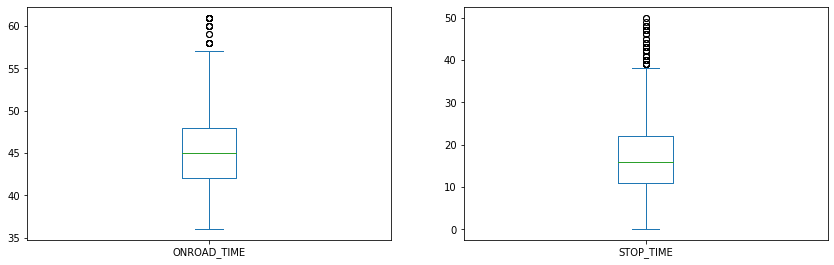

4145_4146


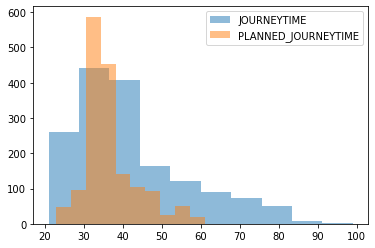

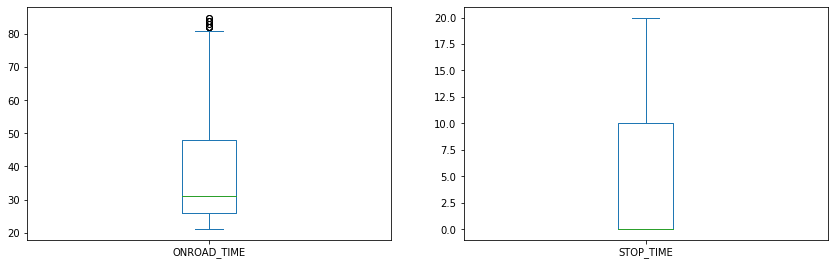

4304_4148


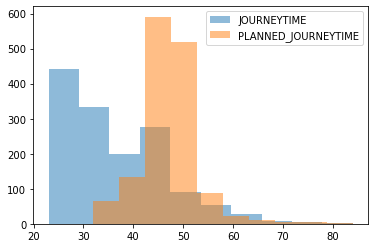

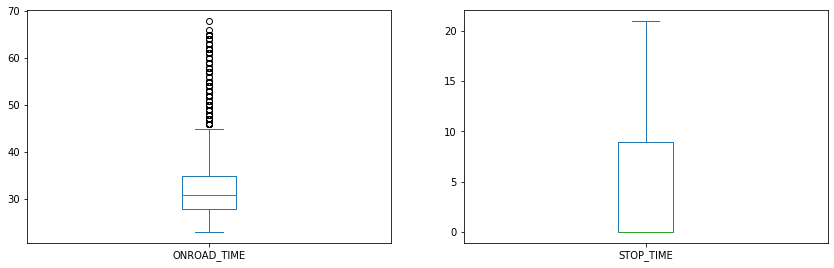

4146_4304


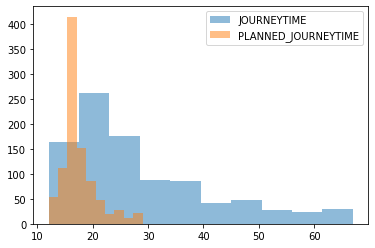

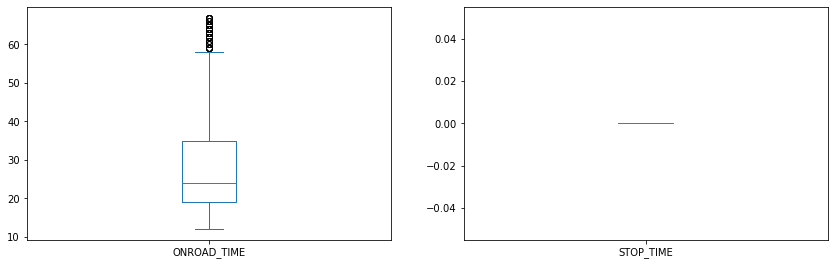

3548_3552


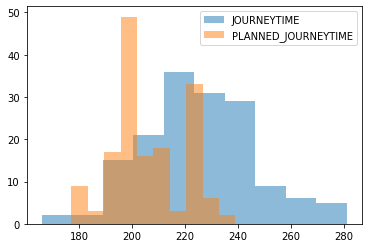

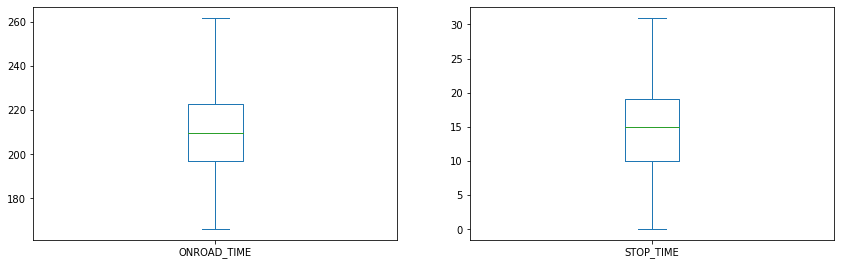

3545_3546


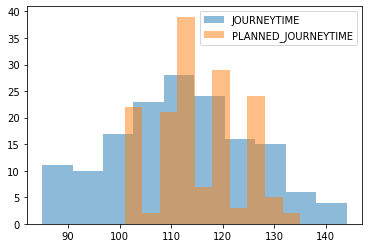

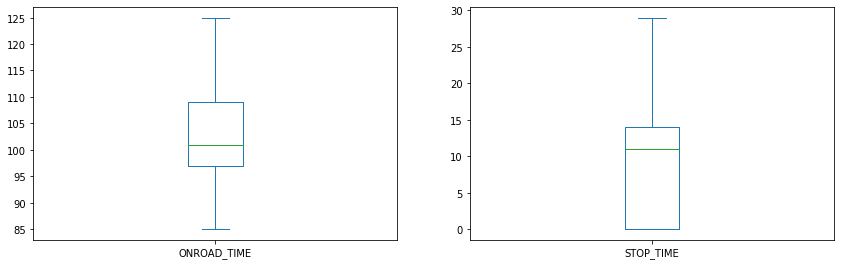

3546_3551


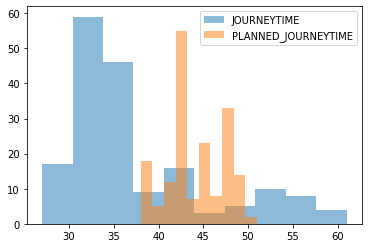

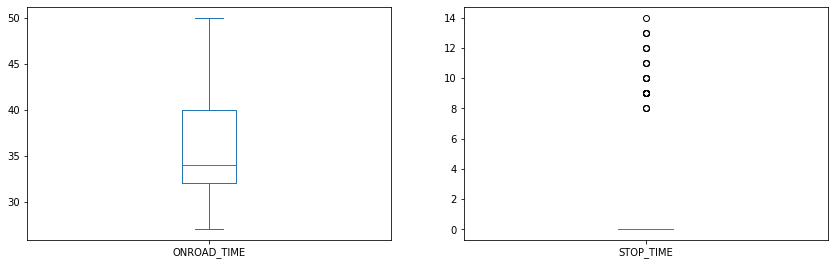

3547_3548


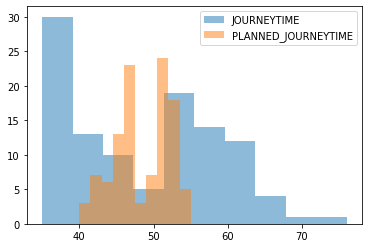

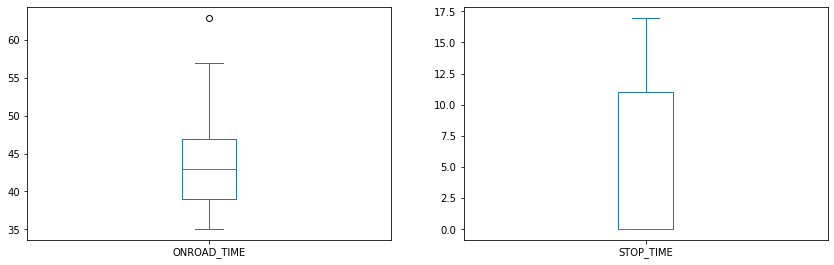

3551_3547


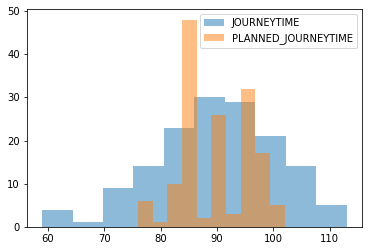

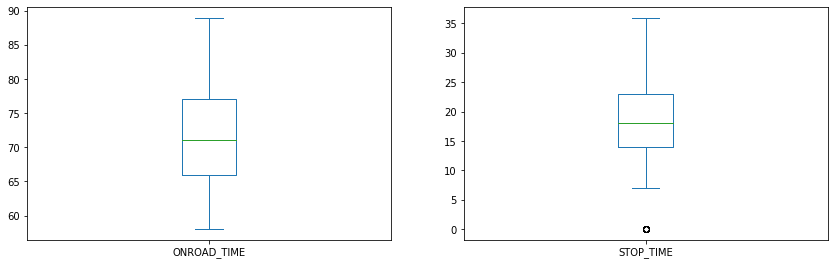

In [37]:
for i in range(start_end_pairs.shape[0]):
    pair = str(start_end_pairs.loc[i, 'STARTSTOP']) + '_' + str(start_end_pairs.loc[i, 'ENDSTOP'])
    print(pair)
    
    data = df.loc[(df['STARTSTOP'] == start_end_pairs.loc[i, 'STARTSTOP']) & (df['ENDSTOP'] == start_end_pairs.loc[i, 'ENDSTOP'])]
    
    # remove outliers
    data = data[(np.abs(stats.zscore(data['ONROAD_TIME'])) > 3) | 
                (np.abs(stats.zscore(data['STOP_TIME'])) > 3)]
    
    df.drop(data.index, inplace = True)
    
    # show plot
    data = df.loc[(df['STARTSTOP'] == start_end_pairs.loc[i, 'STARTSTOP']) & (df['ENDSTOP'] == start_end_pairs.loc[i, 'ENDSTOP'])]

    plt.hist(data['JOURNEYTIME'], alpha=0.5, label='JOURNEYTIME')
    plt.hist(data['PLANNED_JOURNEYTIME'], alpha=0.5, label='PLANNED_JOURNEYTIME')
    plt.legend(loc='upper right')
    
    data[['ONROAD_TIME', 'STOP_TIME']].plot(kind='box', subplots=True, figsize=(30,30), layout=(6,4), sharex=False, sharey=False)

    plt.show()

In [38]:
df['JOURNEYTIME'] = df['STOP_TIME'] + df['ONROAD_TIME']
df[['JOURNEYTIME', 'PLANNED_JOURNEYTIME', 'STOP_TIME', 'ONROAD_TIME']].describe().T

,count,mean,std,min,25%,50%,75%,max
JOURNEYTIME,316922.0,55.575495,40.104646,6.0,28.0,47.0,72.0,493.0
PLANNED_JOURNEYTIME,316922.0,52.998782,31.372547,7.0,31.0,47.0,68.0,330.0
STOP_TIME,316922.0,7.253968,9.764077,0.0,0.0,0.0,13.0,75.0
ONROAD_TIME,316922.0,48.321527,37.206222,6.0,25.0,38.0,60.0,441.0


# Models

In [39]:
df_raw = df.copy()

In [40]:
df = df_raw

In [41]:
df.head()

,STARTSTOP,LINEID,HOUR,ENDSTOP,JOURNEYTIME,PLANNED_JOURNEYTIME,STOP_TIME,MONTH,DAY,ONROAD_TIME,RUSH_HOUR,WEEKDAY
2,4177,45A_2,12,4178,48.0,41.0,22.0,January,Monday,26.0,1,0
3,4178,45A_2,12,4142,69.0,83.0,0.0,January,Monday,69.0,1,0
4,4142,45A_2,12,4143,75.0,62.0,23.0,January,Monday,52.0,1,0
5,4143,45A_2,12,4144,51.0,51.0,14.0,January,Monday,37.0,1,0
6,4144,45A_2,12,5088,26.0,30.0,0.0,January,Monday,26.0,1,0


In [42]:
df = df.drop(['LINEID', 'PLANNED_JOURNEYTIME', 'RUSH_HOUR', 'WEEKDAY'], axis = 1)

In [43]:
df = pd.get_dummies(df, columns = ['MONTH', 'DAY', 'HOUR'], drop_first = True)
df.head()

,STARTSTOP,ENDSTOP,JOURNEYTIME,STOP_TIME,ONROAD_TIME,MONTH_August,MONTH_February,MONTH_January,MONTH_July,MONTH_June,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
2,4177,4178,48.0,22.0,26.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4178,4142,69.0,0.0,69.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4142,4143,75.0,23.0,52.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4143,4144,51.0,14.0,37.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,4144,5088,26.0,0.0,26.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### journey time

In [44]:
# separate data for each start stop
X_trainDict = {}
y_trainDict = {}
X_testDict ={}
y_testDict = {}

# store data for start stops which have few data to train a model
remove = {}

for i in range(start_end_pairs.shape[0]):
    pair = str(start_end_pairs.loc[i, 'STARTSTOP']) + '_' + str(start_end_pairs.loc[i, 'ENDSTOP'])
    print(i, pair)
    
    data = df.loc[(df['STARTSTOP'] == start_end_pairs.loc[i, 'STARTSTOP']) & (df['ENDSTOP'] == start_end_pairs.loc[i, 'ENDSTOP'])]
    
    # check start stops which have few data to train a model
    if data.shape[0] < 100:
        print('----------------------------')
        print(f'the data of {pair} too small')
        print('----------------------------')
        remove[pair] = i
        continue
    
    # drop unnecessary columns
    data.drop(columns=['STARTSTOP', 'ENDSTOP'], inplace=True)    
    
    # target feature is 'JOURNEYTIME'
    y = data['JOURNEYTIME']
    X = data.drop(['JOURNEYTIME', 'ONROAD_TIME', 'STOP_TIME'], axis = 1)
    
    # Split the dataset into two datasets: 70% training and 30% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,  test_size=0.3)
    
    X_trainDict[pair] = X_train
    X_testDict[pair] = X_test
    y_trainDict[pair] = y_train
    y_testDict[pair] = y_test
    
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

0 3555_3556
1 3556_3557
2 3557_3560
3 3560_7323
4 3229_7472
5 3225_3226
6 3226_3227
7 3227_3228
8 3228_3229
9 7323_3561
10 3554_3555
11 3553_3554
12 3240_3068
13 3561_3225
14 3068_3069
15 3069_3070
16 3070_4983
17 3140_3545
18 4206_3140
19 5090_4204
20 4204_4205
21 4203_5090
22 4205_4206
23 4202_4203
24 4201_4202
25 3552_3553
26 3239_3240
27 4416_4201
28 4154_4416
29 4153_4154
30 4150_4151
31 4151_2997
32 7472_3230
33 3238_3239
34 3230_3231
35 3045_4150
36 3237_3238
37 4169_4170
38 4170_4153
39 3236_3237
40 4156_4169
41 3231_3246
42 3246_3247
43 3247_7056
44 4143_4144
45 3248_3343
46 7056_3248
47 3343_3236
48 2997_4156
49 4142_4143
50 4149_3045
51 4178_4142
52 4533_4844
53 4177_4178
54 4844_4177
55 3545_3552
56 4144_5088
57 5088_5089
58 4176_4149
59 5089_4176
60 4148_4149
61 4144_4145
62 4145_4146
63 4304_4148
64 4146_4304
65 3548_3552
66 3545_3546
67 3546_3551
68 3547_3548
69 3551_3547


In [45]:
remove_pairs = pd.DataFrame(columns=['STARTSTOP', 'ENDSTOP'])
remove_pairs

,STARTSTOP,ENDSTOP


In [46]:
for i in remove.values():  
    df1 = start_end_pairs.loc[i, ['STARTSTOP', 'ENDSTOP']]
    df1 = pd.DataFrame(df1).T
    remove_pairs = pd.concat([remove_pairs, df1], ignore_index=True)
    
    start_end_pairs = start_end_pairs.drop(i)
    
remove_pairs

,STARTSTOP,ENDSTOP


In [47]:
if len(remove) > 0:
    start_end_pairs = start_end_pairs.reset_index()

### random forest

In [48]:
# store models for each start stop
models_RF = {}

# train model for each start stop
for i in range(start_end_pairs.shape[0]):
    pair = str(start_end_pairs.loc[i, 'STARTSTOP']) + '_' + str(start_end_pairs.loc[i, 'ENDSTOP'])
    print(i, pair)
    
    # got data for a certain start stop
    X_train = X_trainDict[pair]
    X_test = X_testDict[pair]
    y_train = y_trainDict[pair]
    y_test = y_testDict[pair]
    
    # train models
    rfc = RandomForestRegressor(n_estimators=64, max_features='auto', oob_score=True, random_state=1, min_samples_leaf=0.01)
    rfc.fit(X_train, y_train)
    models_RF[pair] = rfc
    
    # pickle files
    filename = f'pickles/{lineid}_{pair}_RF.sav'
        
    pickle.dump(rfc, open(filename, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

0 3555_3556
1 3556_3557
2 3557_3560
3 3560_7323
4 3229_7472
5 3225_3226
6 3226_3227
7 3227_3228
8 3228_3229
9 7323_3561
10 3554_3555
11 3553_3554
12 3240_3068
13 3561_3225
14 3068_3069
15 3069_3070
16 3070_4983
17 3140_3545
18 4206_3140
19 5090_4204
20 4204_4205
21 4203_5090
22 4205_4206
23 4202_4203
24 4201_4202
25 3552_3553
26 3239_3240
27 4416_4201
28 4154_4416
29 4153_4154
30 4150_4151
31 4151_2997
32 7472_3230
33 3238_3239
34 3230_3231
35 3045_4150
36 3237_3238
37 4169_4170
38 4170_4153
39 3236_3237
40 4156_4169
41 3231_3246
42 3246_3247
43 3247_7056
44 4143_4144
45 3248_3343
46 7056_3248
47 3343_3236
48 2997_4156
49 4142_4143
50 4149_3045
51 4178_4142
52 4533_4844
53 4177_4178
54 4844_4177
55 3545_3552
56 4144_5088
57 5088_5089
58 4176_4149
59 5089_4176
60 4148_4149
61 4144_4145
62 4145_4146
63 4304_4148
64 4146_4304
65 3548_3552
66 3545_3546
67 3546_3551
68 3547_3548
69 3551_3547


In [49]:
mae = {}
mape = {}
mse = {}
rmse = {}
r2 = {}

for i in range(start_end_pairs.shape[0]):
    pair = str(start_end_pairs.loc[i, 'STARTSTOP']) + '_' + str(start_end_pairs.loc[i, 'ENDSTOP'])
   
    X_train = X_trainDict[pair]
    y_train = y_trainDict[pair]
    rfc = models_RF[pair]
        
    rfc_predictions = rfc.predict(X_train).round()
    
    mae[pair] = metrics.mean_absolute_error(y_train, rfc_predictions)
    mape[pair] = metrics.mean_absolute_percentage_error(y_train, rfc_predictions)
    mse[pair] = metrics.mean_squared_error(y_train, rfc_predictions)
    rmse[pair] = metrics.mean_squared_error(y_train, rfc_predictions)**(0.5)
    r2[pair] = metrics.r2_score(y_train, rfc_predictions)

data = {'stop':list(mae.keys()), 'mae':list(mae.values()), 'mape':list(mape.values()), 
        'mse':list(mse.values()), 'rmse':list(rmse.values()), 'r2':list(r2.values())}

models_train_RF = pd.DataFrame.from_dict(data)
models_train_RF

,stop,mae,mape,mse,rmse,r2
0,3555_3556,5.959987,0.146027,56.261375,7.500758,0.420792
1,3556_3557,6.479953,0.426151,59.399473,7.707105,0.177175
2,3557_3560,18.304954,0.260757,492.421716,22.190577,0.152567
3,3560_7323,11.628248,0.181543,209.390628,14.470336,0.264310
4,3229_7472,6.290251,0.200985,61.252316,7.826386,0.191456
...,...,...,...,...,...,...
65,3548_3552,13.522936,0.060273,293.431193,17.129833,0.297636
66,3545_3546,8.672897,0.077812,122.074766,11.048745,0.336035
67,3546_3551,5.162602,0.132018,47.292683,6.876968,0.288574
68,3547_3548,5.236842,0.111555,49.394737,7.028139,0.541491


In [50]:
mae = {}
mape = {}
mse = {}
rmse = {}
r2 = {}

for i in range(start_end_pairs.shape[0]):
    pair = str(start_end_pairs.loc[i, 'STARTSTOP']) + '_' + str(start_end_pairs.loc[i, 'ENDSTOP'])
   
    X_test = X_testDict[pair]
    y_test = y_testDict[pair]
    rfc = models_RF[pair]
        
    rfc_predictions = rfc.predict(X_test)
    
    mae[pair] = metrics.mean_absolute_error(y_test, rfc_predictions)
    mape[pair] = metrics.mean_absolute_percentage_error(y_test, rfc_predictions)
    mse[pair] = metrics.mean_squared_error(y_test, rfc_predictions)
    rmse[pair] = metrics.mean_squared_error(y_test, rfc_predictions)**(0.5)
    r2[pair] = metrics.r2_score(y_test, rfc_predictions)

data = {'stop':list(mae.keys()), 'mae':list(mae.values()), 'mape':list(mape.values()), 
        'mse':list(mse.values()), 'rmse':list(rmse.values()), 'r2':list(r2.values())}

models_test_RF = pd.DataFrame.from_dict(data)
models_test_RF

,stop,mae,mape,mse,rmse,r2
0,3555_3556,5.721081,0.140995,53.015766,7.281193,0.429009
1,3556_3557,6.333817,0.419379,56.821239,7.537986,0.206725
2,3557_3560,17.944940,0.254549,469.946732,21.678255,0.157365
3,3560_7323,11.887697,0.187460,221.663928,14.888382,0.197760
4,3229_7472,6.428482,0.207022,63.065996,7.941410,0.162138
...,...,...,...,...,...,...
65,3548_3552,18.706749,0.088429,530.395101,23.030308,-0.073655
66,3545_3546,13.048079,0.124704,233.787102,15.290098,-0.459427
67,3546_3551,6.470301,0.167840,70.603514,8.402590,-0.288384
68,3547_3548,8.106494,0.176110,93.829666,9.686571,-0.275471


In [51]:
models_train_RF[['mape', 'r2']].describe().T

,count,mean,std,min,25%,50%,75%,max
mape,70.0,0.232495,0.122048,0.060066,0.139136,0.207398,0.279093,0.716195
r2,70.0,0.268352,0.143699,0.020465,0.161009,0.246563,0.359695,0.652649


In [52]:
models_test_RF[['mape', 'r2']].describe().T

,count,mean,std,min,25%,50%,75%,max
mape,70.0,0.238895,0.122003,0.064357,0.152807,0.210743,0.279445,0.746090
r2,70.0,0.203301,0.198163,-0.459427,0.110343,0.204319,0.319827,0.635677


In [53]:
models_train_RF['lineid'] = lineid
models_test_RF['lineid'] = lineid

In [54]:
models_train_RF.to_csv(f'result/{lineid}_train.csv', index = False)
models_test_RF.to_csv(f'result/{lineid}_test.csv', index = False)

In [55]:
remove_pairs.to_csv(f'result/{lineid}_remove.csv', index = False)